In [ ]:
import matplotlib.pyplot as plt
import numpy as np

N = 10

x0, xN = 0, 1

h = (xN - x0) / N
x = np.linspace(x0, xN, N + 1)

u_exact = (x + 1) * np.exp(-x)

p = -1
q = -2
f = -3 * np.exp(-x)

In [ ]:
def f(x):
    return np.pi**2 * np.sin(np.pi * x)


def phi(k, x):
    return np.sin(k * np.pi * x)


def dphi(k, x):
    return k * np.pi * np.cos(k * np.pi * x)


A = np.zeros((N, N))
b = np.zeros(N)


x_vals = np.linspace(0, 1, 1000)
dx = x_vals[1] - x_vals[0]

for i in range(N):
    for j in range(N):
        integrand = dphi(i + 1, x_vals) * dphi(j + 1, x_vals)
        A[i, j] = np.trapezoid(integrand, x_vals)

    integrand_b = f(x_vals) * phi(i + 1, x_vals)
    b[i] = np.trapezoid(integrand_b, x_vals)

c = np.linalg.solve(A, b)

u_approx = np.zeros_like(x_vals)
for i in range(N):
    u_approx += c[i] * phi(i + 1, x_vals)

u_exact = np.sin(np.pi * x_vals)

print(np.abs(u_approx - u_exact).max())

8.326672684688674e-17


C:\Users\kirde\AppData\Local\Temp\ipykernel_24476\1199777359.py:24: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  b[i] = 2 * np.trapz(f(x) * phi(i + 1, x), x)


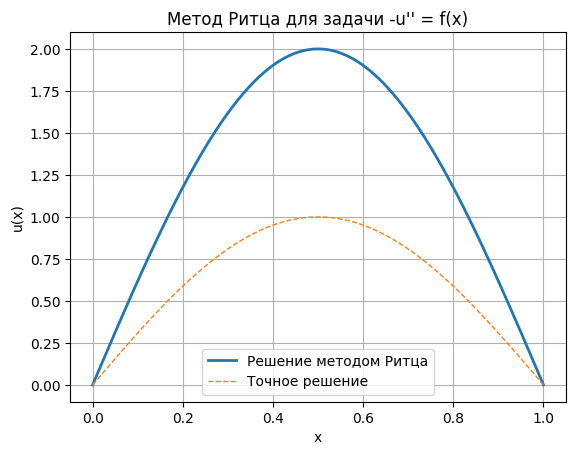

In [ ]:
def f(x):
    return np.pi**2 * np.sin(np.pi * x)


# Базисные функции: φ_k(x) = sin(kπx), удовлетворяют граничным условиям
def phi(k, x):
    return np.sin(k * np.pi * x)


# Производная базисной функции
def dphi(k, x):
    return k * np.pi * np.cos(k * np.pi * x)


# Вычисление коэффициентов системы методом Ритца
def build_system(N):
    A = np.zeros((N, N))
    b = np.zeros(N)
    for i in range(N):
        for j in range(N):
            # Интеграл от φ_i' * φ_j'
            if i == j:
                A[i, j] = (np.pi * (i + 1)) ** 2 / 2
            else:
                A[i, j] = 0  # Ортогональность производных синусов
        # Интеграл от f * φ_i
        b[i] = 2 * np.trapz(f(x) * phi(i + 1, x), x)
    return A, b


# Сетка
x = np.linspace(0, 1, 1000)

# Сборка системы
A, b = build_system(N)

# Решение СЛАУ
c = np.linalg.solve(A, b)

# Восстановление решения
u_ritz = np.zeros_like(x)
for i in range(N):
    u_ritz += c[i] * phi(i + 1, x)

# Точное решение для сравнения
u_exact = np.sin(np.pi * x)


# График
plt.plot(x, u_ritz, label="Решение методом Ритца", linewidth=2)
plt.plot(x, u_exact, "--", label="Точное решение", linewidth=1)
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.grid(True)
plt.title("Метод Ритца для задачи -u'' = f(x)")
plt.show()

In [ ]:
import sympy as sp

# Переменная и параметры
x = sp.Symbol("x")
n = 2  # количество базисных функций (можно увеличить для более точного решения)

# Базисные функции, удовлетворяющие граничным условиям: u(-1) = u(1) = 0
phi = [x * (1 - x**2) ** i for i in range(1, n + 1)]

# Приближенное решение: линейная комбинация базисных функций
a = sp.symbols(f"a0:{n}")
u_approx = sum(a[i] * phi[i] for i in range(n))

# Вычисление функционала метода Ритца
u_approx_dx = sp.diff(u_approx, x)
u_approx_d2x = sp.diff(u_approx_dx, x)
integrand = (u_approx_dx) ** 2 + (1 + x**2) * u_approx**2 + 2 * u_approx
J = sp.integrate(integrand, (x, -1, 1))

# Выводим уравнения: производные функционала по коэффициентам = 0
eqs = [sp.diff(J, ai) for ai in a]

# Решение системы уравнений
sol = sp.solve(eqs, a)

# Подстановка коэффициентов в приближенное решение
u_sol = u_approx.subs(sol)

# Упрощение результата
u_sol = sp.simplify(u_sol)

print("Приближенное решение u(x):")
sp.pprint(u_sol)

Приближенное решение u(x):
0


In [20]:
import numpy as np
from scipy.integrate import quad
from scipy.linalg import solve
import matplotlib.pyplot as plt


class RitzMethodSolver:
    def __init__(self, p_func, q_func, f_func, a=-1, b=1, u_a=0, u_b=0, n=5):
        """
        Инициализация решателя краевой задачи методом Ритца

        Параметры:
        p_func - функция p(x) в уравнении -(p(x)u')' + q(x)u = f(x)
        q_func - функция q(x)
        f_func - функция f(x)
        a, b - границы интервала
        u_a, u_b - граничные условия u(a) и u(b)
        n - количество базисных функций
        """
        self.p_func = p_func
        self.q_func = q_func
        self.f_func = f_func
        self.a = a
        self.b = b
        self.u_a = u_a
        self.u_b = u_b
        self.n = n

        # Базисные функции φ_i(x) = (x-a)(x-b)x^{i-1}
        self.basis = [lambda x, i=i: (x - a) * (x - b) * x ** (i) for i in range(n)]
        # Производные базисных функций
        self.basis_deriv = [self._get_derivative(phi) for phi in self.basis]

    def _get_derivative(self, f, h=1e-5):
        """Численное вычисление производной функции"""
        return lambda x: (f(x + h) - f(x - h)) / (2 * h)

    def compute_matrix_elements(self):
        """Вычисление элементов матрицы A и вектора b системы уравнений"""
        A = np.zeros((self.n, self.n))
        b = np.zeros(self.n)

        for i in range(self.n):
            for j in range(i, self.n):
                # Интеграл для элемента A[i,j]
                integrand = lambda x: (
                    self.p_func(x) * self.basis_deriv[i](x) * self.basis_deriv[j](x)
                    + self.q_func(x) * self.basis[i](x) * self.basis[j](x)
                )
                A[i, j], _ = quad(integrand, self.a, self.b)
                if i != j:
                    A[j, i] = A[i, j]  # Матрица симметричная

            # Интеграл для элемента b[i]
            integrand_b = lambda x: self.f_func(x) * self.basis[i](x)
            b[i], _ = quad(integrand_b, self.a, self.b)

        return A, b

    def solve(self):
        """Решение краевой задачи"""
        A, b = self.compute_matrix_elements()
        c = solve(A, b)  # Решение системы линейных уравнений

        # Создаем функцию-решение
        def solution(x):
            result = 0
            for i in range(self.n):
                result += c[i] * self.basis[i](x)
            return result + self._boundary_term(x)

        # Добавляем граничные члены
        def boundary_term(x):
            return self.u_a + (x - self.a) / (self.b - self.a) * (self.u_b - self.u_a)

        self._boundary_term = boundary_term

        return solution

    def plot_solution(self, solution, num_points=100):
        """Визуализация решения"""
        x_vals = np.linspace(self.a, self.b, num_points)
        u_vals = [solution(x) for x in x_vals]

        plt.figure(figsize=(8, 6))
        plt.plot(x_vals, u_vals, label="Приближенное решение")
        plt.xlabel("x")
        plt.ylabel("u(x)")
        plt.title("Решение краевой задачи методом Ритца")
        plt.grid(True)
        plt.legend()
        plt.show()


# Пример использования для задачи из примера 2
if __name__ == "__main__":
    # Преобразуем уравнение u'' + (1 + x^2)u + 1 = 0 к виду -(p(x)u')' + q(x)u = f(x)
    # Здесь p(x) = 1, q(x) = -(1 + x^2), f(x) = -1
    p_func = lambda x: 1
    q_func = lambda x: -(1 + x**2)
    f_func = lambda x: -1

    # Создаем решатель
    solver = RitzMethodSolver(p_func, q_func, f_func, a=-1, b=1, u_a=0, u_b=0, n=100)

    x_vals = np.linspace(-1, 1, 1000)


    solution = solver.solve()

    exact = lambda x: (0.934 - 0.988 * x**2 + 0.054 * x**4) * (-1)

    print("Максимальная ошибка:", np.abs(solution(x_vals) - exact(x_vals)).max())

Максимальная ошибка: 0.001946224734759805


C:\Users\kirde\AppData\Local\Temp\ipykernel_24476\2482892407.py:63: LinAlgWarning: Ill-conditioned matrix (rcond=3.52764e-19): result may not be accurate.
  c = solve(A, b)  # Решение системы линейных уравнений
